Testing Mushi
==

Here's a notebook for playing with the `mushi` module

API documentation can be viewed with
```python
help(PiecewiseConstantHistory)
help(JointHistory)
help(SFS)
```

In [1]:
%matplotlib notebook
import mushi
from mushi import PiecewiseConstantHistory, JointHistory, SFS
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

### Demographic history $\eta(t)$ and mutation rate history $\mu(t)$

<IPython.core.display.Javascript object>


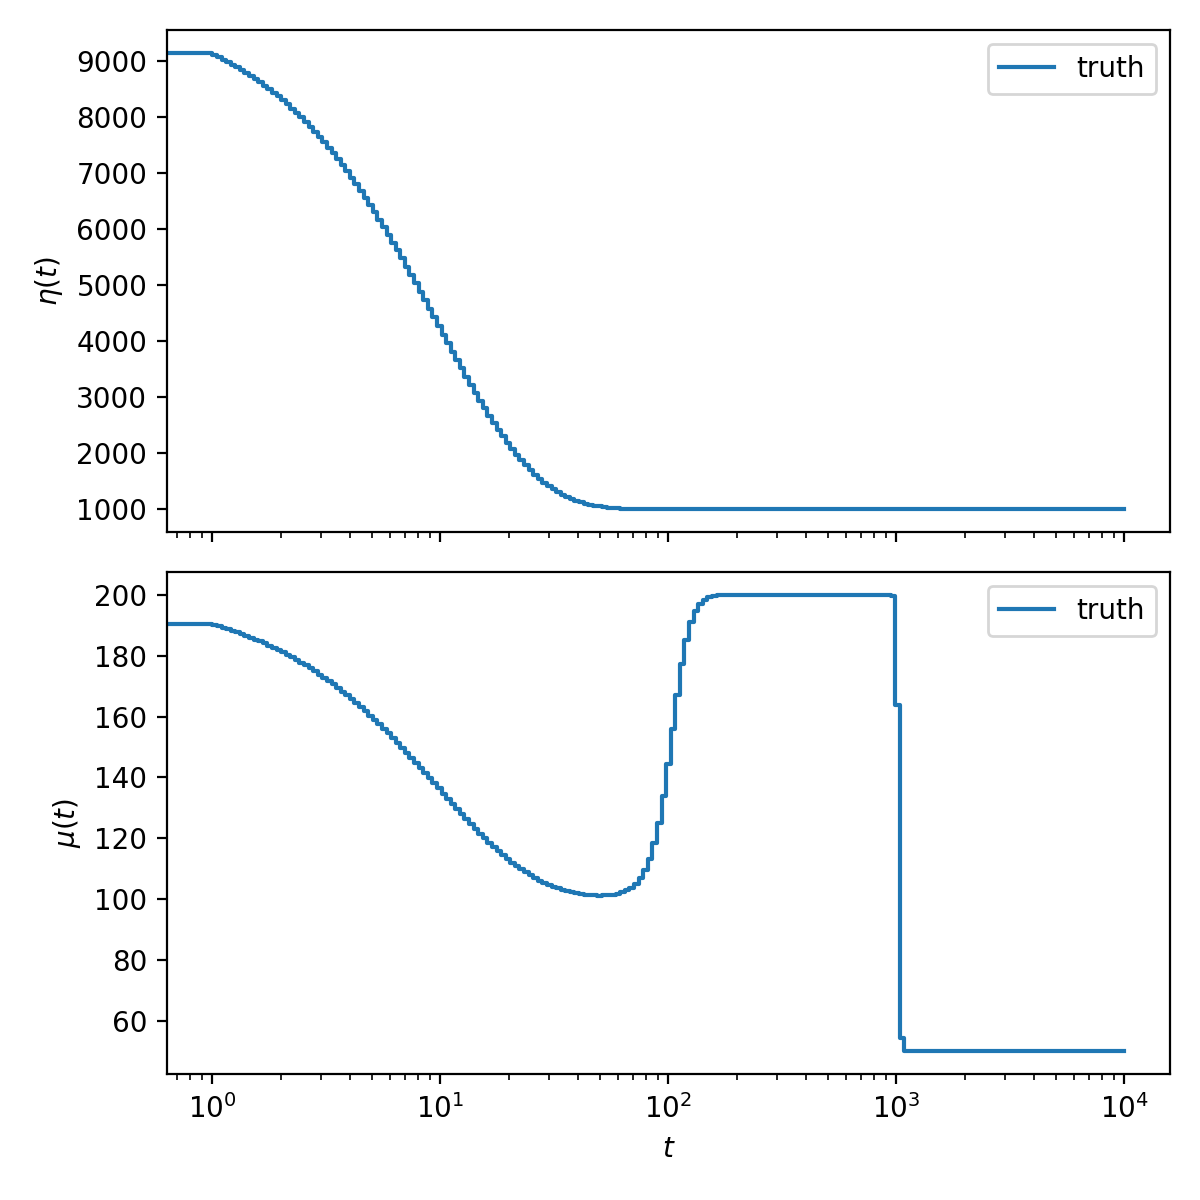

In [23]:
t = np.logspace(0, 4, 200)

y = 1000 * np.ones(len(t) + 1)
y[:-1] += 9000 * np.exp(- .1 * t)
η = PiecewiseConstantHistory(t, y)

z = np.ones(len(t) + 1)
z[1:] += expit(.1 * (t - 100)) - 1.5 * expit(.1 * (t - 1000))
z[:-1] += 1 * np.exp(- .1 * t)
μ = PiecewiseConstantHistory(t, 100 * z)

history = JointHistory(η, μ)

fig = history.plot(label='truth')
plt.xscale('log')
plt.tight_layout()
plt.show()

### Simulate a SFS under this history
Plot the SFS and the CDF of the TMRCA of the sample

<IPython.core.display.Javascript object>


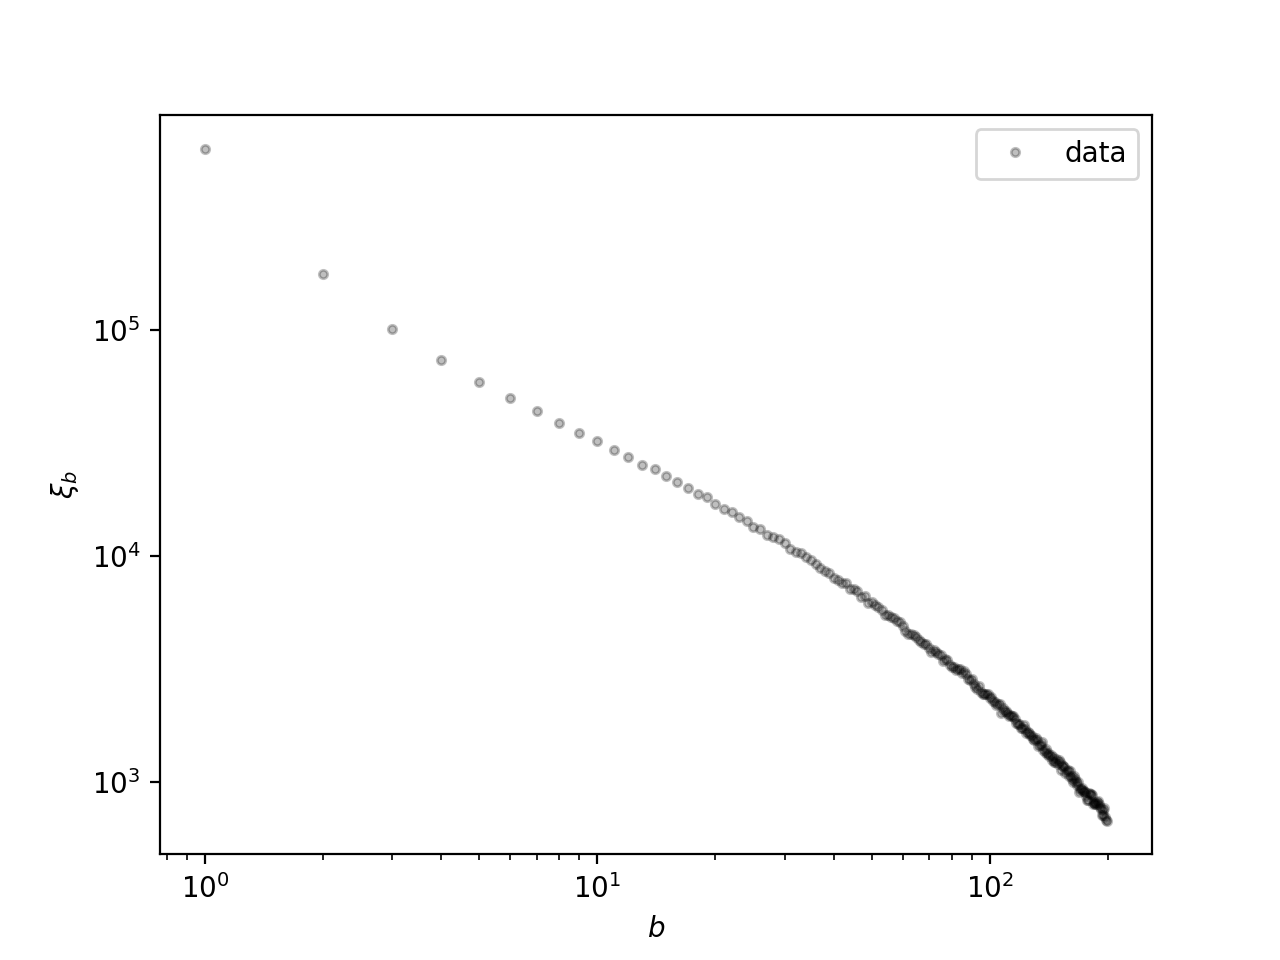

<IPython.core.display.Javascript object>


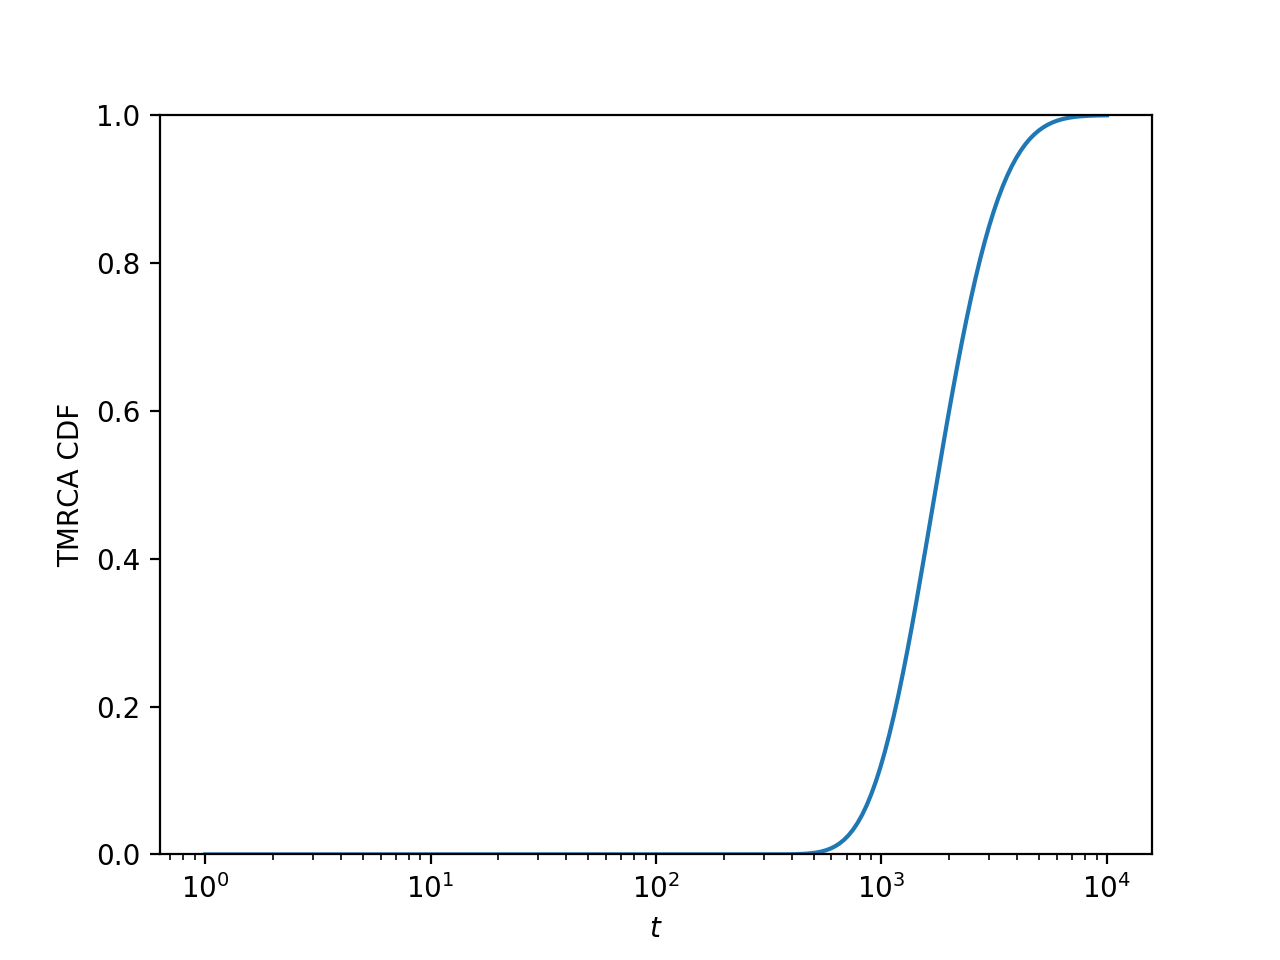

In [24]:
n = 200
sfs = SFS(n)
sfs.simulate(history, seed=1)

plt.figure()
sfs.plot()
plt.show()

plt.figure()
plt.plot(η.change_points, sfs.tmrca_cdf(history.η))
plt.xlabel('$t$')
plt.xscale('log')
plt.ylim([0, 1])
plt.ylabel('TMRCA CDF')
plt.show()

### Invert the `TCC>TTC` SFS conditioned on $\eta(t)$ to get $\mu(t)$
We perform two inferences and plot the results:
- inference of $\eta$ conditioned on the true $\mu$
- inference of $\mu$ conditioned on the true $\eta$

<IPython.core.display.Javascript object>


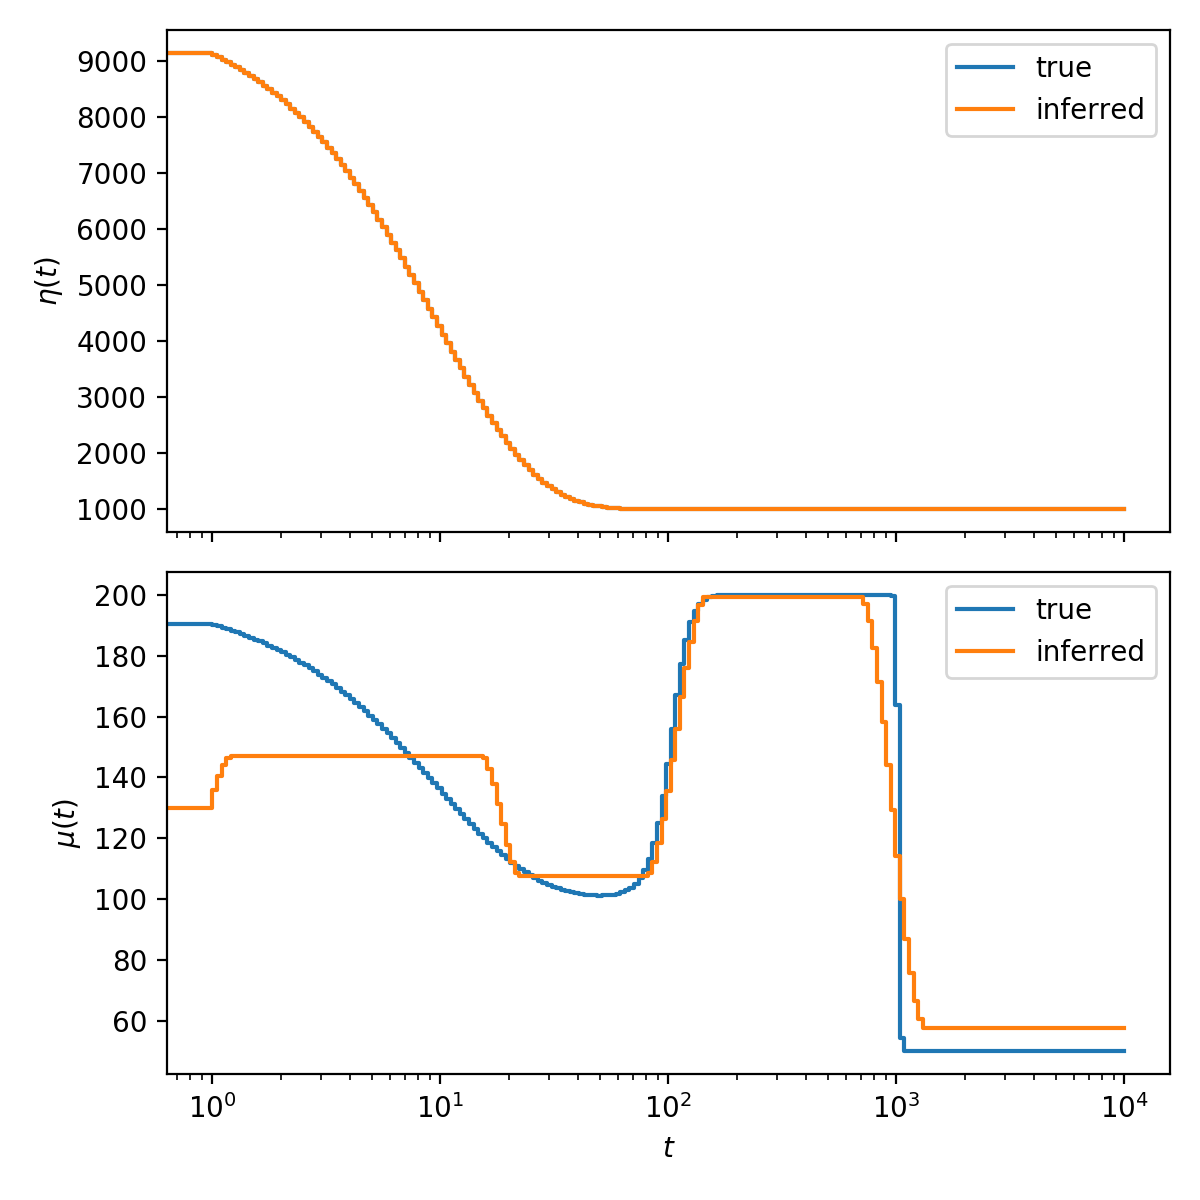

<IPython.core.display.Javascript object>


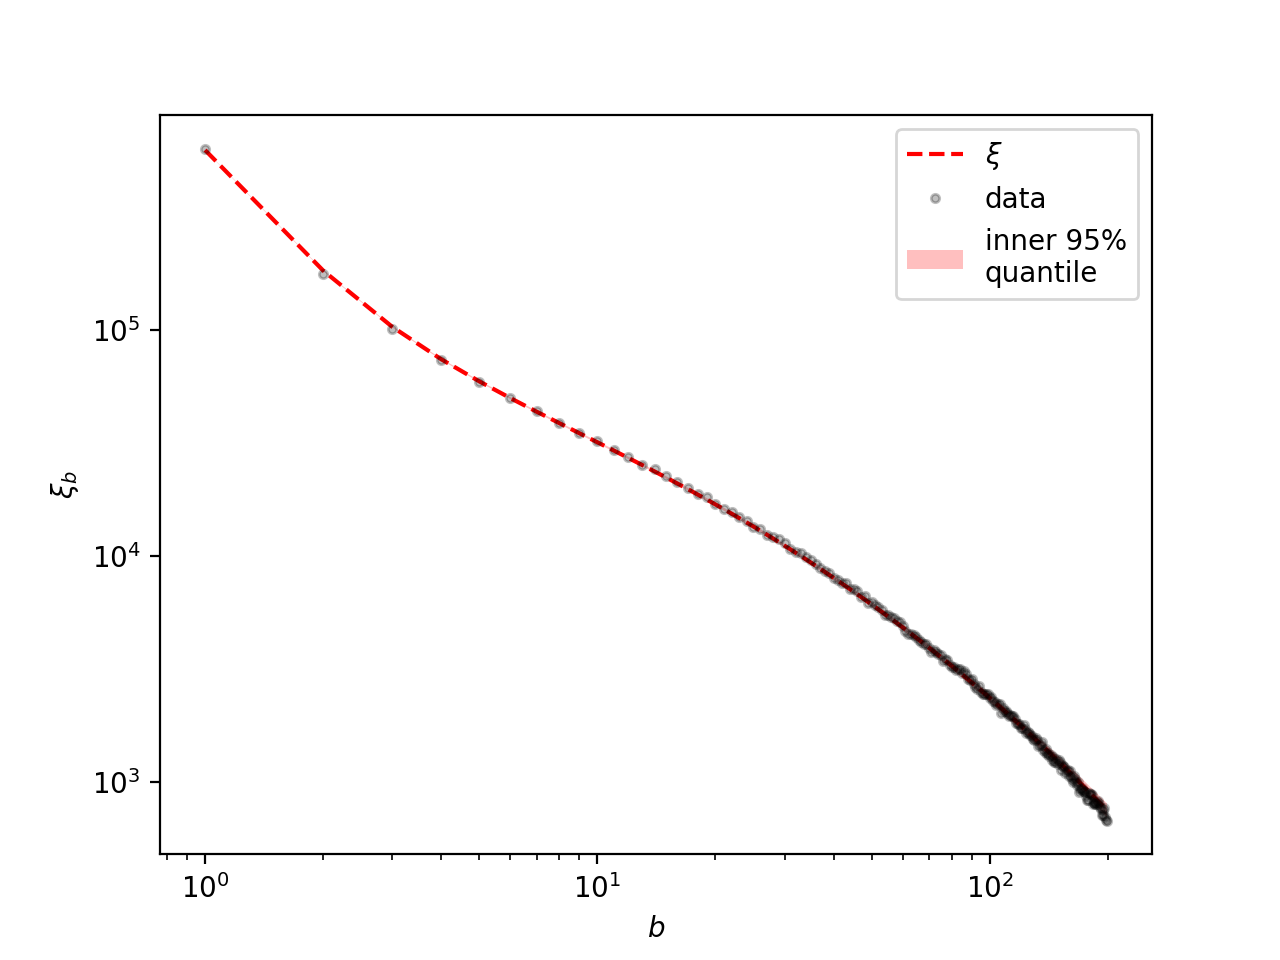

In [29]:
# η fit
λ = 1e-6
α = 0
s = 1e-3
steps = 10
# η_inferred = sfs.infer_η(μ, λ=λ, α=α, s=s, steps=steps)
η_inferred = η

# μ fit
λ = 1e1
α = .99
s = 1e0
steps = 20000
μ_inferred = sfs.infer_μ(η, λ=λ, α=α, s=s, steps=steps)
# μ_inferred = μ

# joint history from each marginal inference
history_inferred = JointHistory(η_inferred, μ_inferred)

fig = history.plot(label='true')
history_inferred.plot(fig=fig, label='inferred')
plt.xscale('log')
plt.tight_layout()
plt.show()

plt.figure()
sfs.plot(history_inferred)
plt.show()